In [1]:
%matplotlib inline
import json
import numpy as np
import glob
import matplotlib.pyplot as plt
import brewer2mpl
import math
import pandas as pd
bmap = brewer2mpl.get_map('Set2', 'qualitative', 8)
colors = bmap.mpl_colors

In [2]:
LOGDIR = '../results1000/'
PARAMS = ['hsarst_future_comp_1_inf_tanh_True_True_1000_0.3/',
          'hsarst_future_init_1_inf_tanh_True_True_1000_0.3/',
          'hsarst_future_intervalC_1_inf_tanh_True_True_1000_0.3/',
          'hsarst_future_rnd_1_inf_tanh_True_True_1000_0.3/'
         ]

In [3]:
frames = []
for PARAM in PARAMS:
    param_vals = PARAM.split('_')
    param_names = ['memory', 'strategy', 'sampler', 'alpha', 'delta', 'activation', 'invert_grads', 'target_clip']
    res_steps = glob.glob(LOGDIR + PARAM + '/*/' + 'log_steps/progress.json')
    for num_run, run in enumerate(res_steps):
        try:
            df = pd.read_json(run, lines=True)
        except ValueError:
            print("run "+run+": invalid")
        df['params'] = PARAM
        df['num_run']=num_run
        frames.append(df)
expe_res_steps = pd.concat(frames, ignore_index=True)
expe_res_steps

,Test reward on initial goal,Test reward on random goal,critic_loss,d_q_values,mean_Q_values,mean_action,mean_target_Q_values,mean_target_action,num_run,params,q_values,reference_action_grads,training_step
0,NaN,NaN,0.000319,"[0.017474662512540002, 0.017372909933328, 0.01...",-0.013109,-0.019189,-0.010514,0.006513,0,hsarst_future_comp_1_inf_tanh_True_True_1000_0.3/,"[0.017474662512540002, 0.017372909933328, 0.01...",-0.000233,200
1,NaN,NaN,0.000013,"[0.017474662512540002, 0.017372909933328, 0.01...",-0.014175,-0.012849,-0.007755,0.001029,0,hsarst_future_comp_1_inf_tanh_True_True_1000_0.3/,"[0.017474662512540002, 0.017372909933328, 0.01...",0.001835,400
2,NaN,NaN,0.000003,"[0.017474662512540002, 0.017372909933328, 0.01...",-0.011426,0.061714,-0.006149,0.003374,0,hsarst_future_comp_1_inf_tanh_True_True_1000_0.3/,"[0.017474662512540002, 0.017372909933328, 0.01...",0.000989,600
3,NaN,NaN,0.000003,"[0.017474662512540002, 0.017372909933328, 0.01...",-0.012442,0.024328,-0.007430,0.004374,0,hsarst_future_comp_1_inf_tanh_True_True_1000_0.3/,"[0.017474662512540002, 0.017372909933328, 0.01...",-0.000864,800
4,-0.128420,9.707373,539.184998,"[0.017474662512540002, 0.017372909933328, 0.01...",13.643380,-0.701141,0.045324,-0.021944,0,hsarst_future_comp_1_inf_tanh_True_True_1000_0.3/,"[0.017474662512540002, 0.017372909933328, 0.01...",-0.558383,1000
5,-0.128420,9.707373,639.629883,"[0.017474662512540002, 0.017372909933328, 0.01...",17.795673,-0.996751,0.500171,-0.168696,0,hsarst_future_comp_1_inf_tanh_True_True_1000_0.3/,"[0.017474662512540002, 0.017372909933328, 0.01...",-1.844185,1200
6,-0.128420,9.707373,567.550537,"[0.017474662512540002, 0.017372909933328, 0.01...",17.738554,-0.998503,1.389236,-0.409980,0,hsarst_future_comp_1_inf_tanh_True_True_1000_0.3/,"[0.017474662512540002, 0.017372909933328, 0.01...",-2.061660,1400
7,-0.128420,9.707373,481.086731,"[0.017474662512540002, 0.017372909933328, 0.01...",17.362259,-0.998910,2.553590,-0.654765,0,hsarst_future_comp_1_inf_tanh_True_True_1000_0.3/,"[0.017474662512540002, 0.017372909933328, 0.01...",-1.066737,1600
8,-0.128420,9.707373,467.141479,"[0.017474662512540002, 0.017372909933328, 0.01...",26.329504,-0.998953,4.624844,-0.837246,0,hsarst_future_comp_1_inf_tanh_True_True_1000_0.3/,"[0.017474662512540002, 0.017372909933328, 0.01...",-2.002608,1800
9,-26.732358,-20.734036,365.346924,"[0.017474662512540002, 0.017372909933328, 0.01...",28.303528,-0.999826,6.666426,-0.910576,0,hsarst_future_comp_1_inf_tanh_True_True_1000_0.3/,"[0.017474662512540002, 0.017372909933328, 0.01...",-4.848110,2000


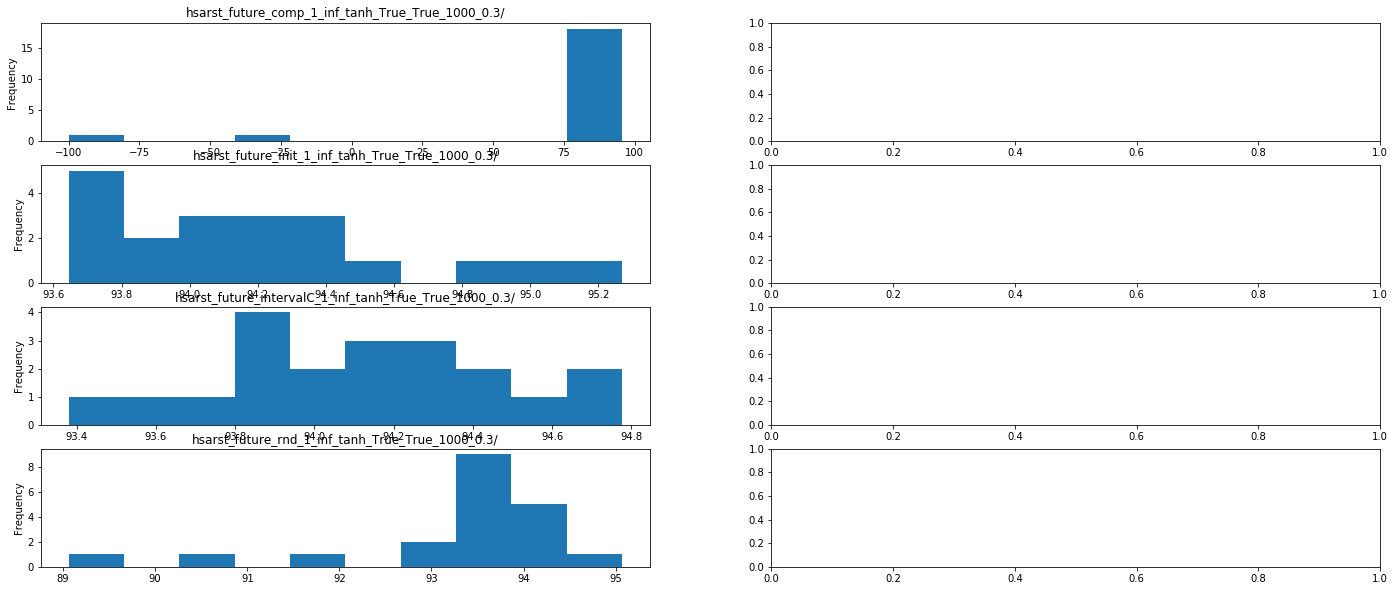

In [4]:
res_final = expe_res_steps[expe_res_steps['training_step']==200000]
fig, axes = plt.subplots(4,2, figsize=(24,10))
for i,(name, g) in enumerate(res_final.groupby('params')['Test reward on initial goal']):
    g.plot(kind='hist', title=name, ax=axes[i%4, i//4])

In [5]:
dico = {}
for name, g in expe_res_steps[expe_res_steps['training_step']==200000].groupby('params'):
    dico[name] = list(g[g['Test reward on initial goal']>20]['num_run'].values)
mask = expe_res_steps.apply(lambda g: g['num_run'] in dico[g['params']], axis=1)
filtered = expe_res_steps[mask]

In [6]:
def quant_inf(x) : return x.quantile(0.2)
def quant_sup(x) : return x.quantile(0.8)
op_dict = {'Test reward on initial goal':[np.mean, np.median, quant_inf,quant_sup]}
columns = ['Test reward on initial goal','training_step','params']
stats_eval_init = filtered[columns].groupby(['training_step','params']).agg(op_dict).reset_index()

In [7]:
stats_eval_init_smooth = stats_eval_init[['params','Test reward on initial goal']].groupby('params').apply(lambda x: x.ewm(30).mean())
stats_eval_init_smooth['training_step'] = stats_eval_init['training_step']

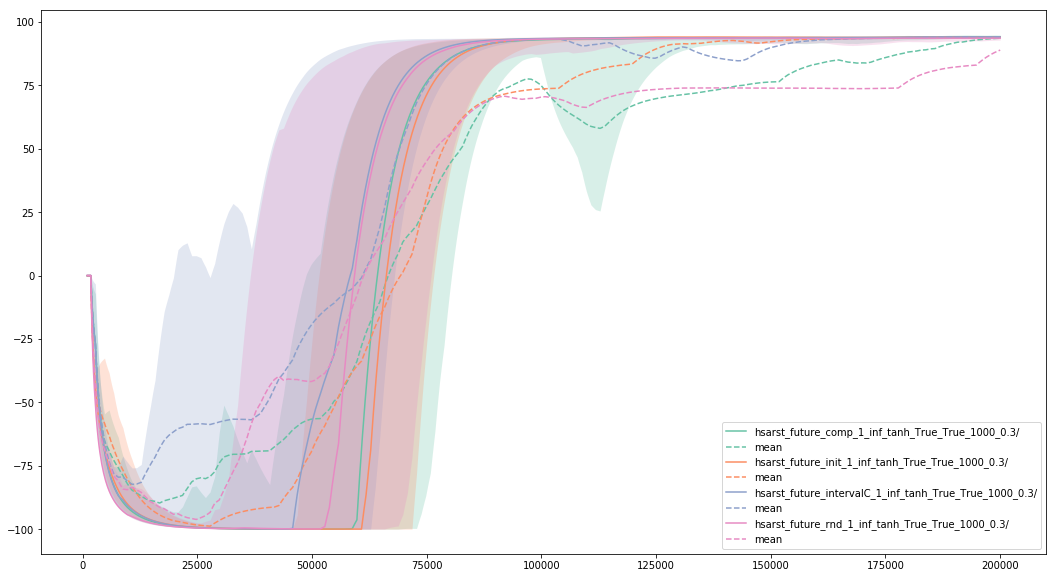

In [10]:
fig, ax = plt.subplots(figsize=(18,10))
for i, (name, g) in enumerate(stats_eval_init_smooth.groupby(['params'])):
    if name in PARAMS:
        ax.plot(g['training_step'], g['Test reward on initial goal']['median'], label=name, color=colors[i])
        ax.plot(g['training_step'], g['Test reward on initial goal']['mean'], color=colors[i], linestyle='dashed')
        ax.fill_between(g['training_step'], 
                        g['Test reward on initial goal']['quant_inf'], 
                        g['Test reward on initial goal']['quant_sup'], alpha=0.25, linewidth=0, color=colors[i])
ax.legend(loc=4)

In [15]:
means_steps = expe_res_steps.groupby(['training_step','params']).mean()
means_steps.reset_index(level=['training_step', 'params'], inplace=True)
means_steps

,training_step,params,Test reward on initial goal,Test reward on random goal,critic_loss,mean_Q_values,mean_action,mean_target_Q_values,mean_target_action,num_run,reference_action_grads
0,200,hsarst_final_rnd_1_inf_tanh_True_True_200,NaN,NaN,160.045518,2.026046,0.040123,0.004600,0.006068,9.5,0.013705
1,200,hsarst_future_rnd_1_inf_tanh_True_True_200,NaN,NaN,294.593283,6.701143,-0.106886,0.020093,-0.008882,9.5,0.002265
2,200,sarst_final_comp_1_inf_tanh_True_True_200,NaN,NaN,7.794630,0.013958,0.004855,0.000029,-0.003531,9.5,-0.000171
3,200,sarst_final_intervalC_1_inf_tanh_True_True_200,NaN,NaN,2.927530,0.010848,0.004666,0.005298,-0.001938,9.5,-0.000150
4,200,sarst_final_rnd_1_inf_tanh_True_True_200,NaN,NaN,5.607081,0.022078,-0.009665,-0.001834,0.000897,19.5,-0.000471
5,400,hsarst_final_rnd_1_inf_tanh_True_True_200,NaN,NaN,735.522202,22.399515,0.145414,0.121125,0.009188,9.5,0.212813
6,400,hsarst_future_rnd_1_inf_tanh_True_True_200,NaN,NaN,1072.798895,44.317705,0.124283,0.230423,-0.006343,9.5,0.443676
7,400,sarst_final_comp_1_inf_tanh_True_True_200,NaN,NaN,10.032394,0.167451,0.031822,0.008825,-0.003284,9.5,0.008468
8,400,sarst_final_intervalC_1_inf_tanh_True_True_200,NaN,NaN,2.448528,0.029927,0.076892,0.004489,-0.000371,9.5,0.003054
9,400,sarst_final_rnd_1_inf_tanh_True_True_200,NaN,NaN,8.071793,0.119926,0.015030,0.003052,0.000257,19.5,-0.003367


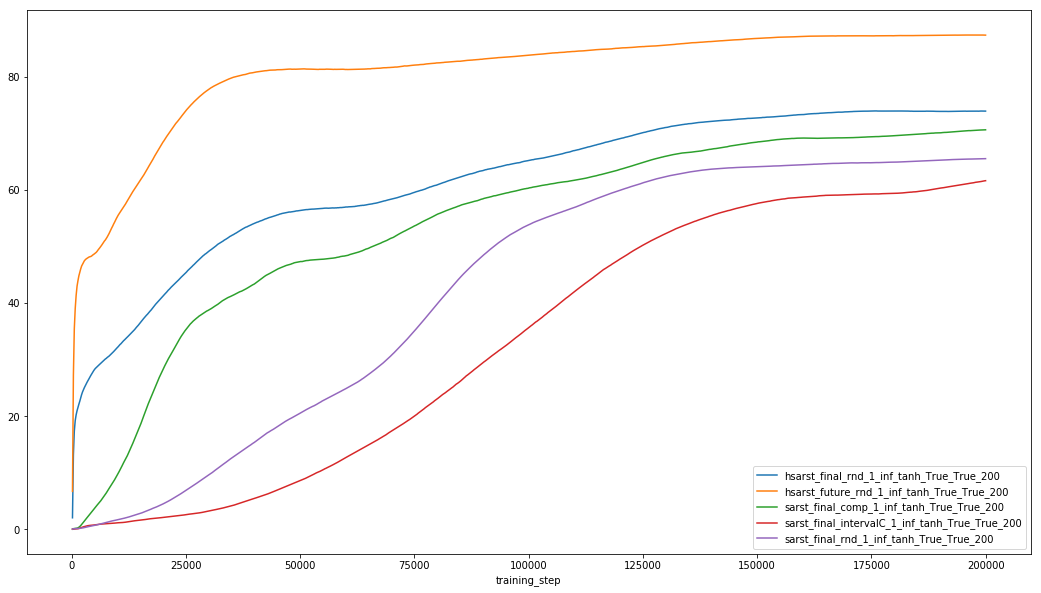

In [16]:
means_steps['mean_Q_values'] = means_steps.groupby('params')['mean_Q_values'].apply(lambda x: x.ewm(5).mean())
fig, ax = plt.subplots(figsize=(18,10))
for name, g in means_steps.groupby(['params'])[['training_step','mean_Q_values']]:
    g.plot(x='training_step',y='mean_Q_values', label=name, ax=ax)

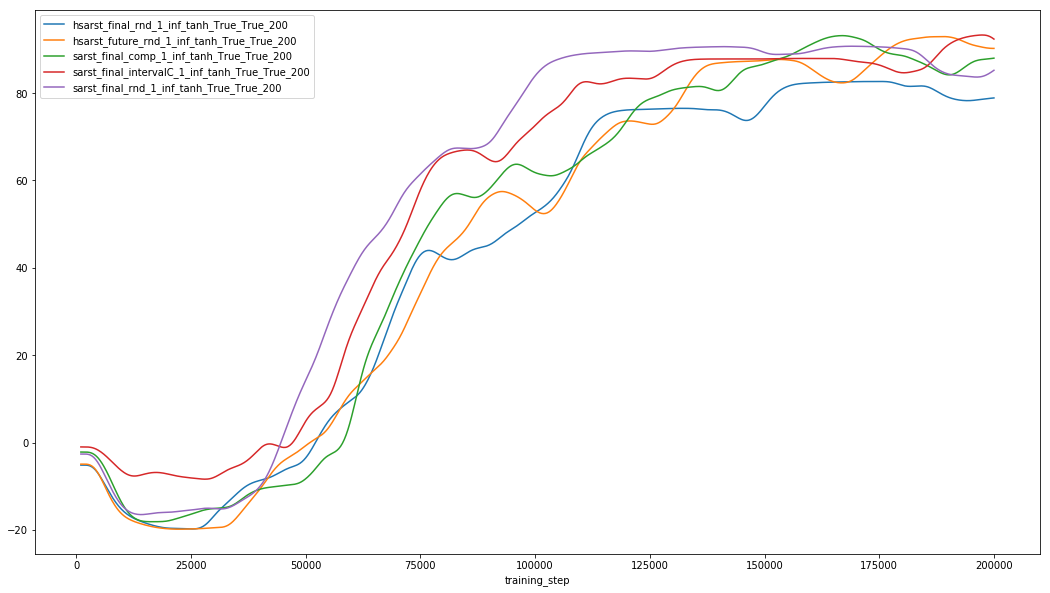

In [35]:
means_steps['Test reward on initial goal'] = means_steps.groupby('params')['Test reward on initial goal'].apply(lambda x: x.ewm(5).mean())
fig, ax = plt.subplots(figsize=(18,10))
for name, g in means_steps.groupby(['params'])[['training_step','Test reward on initial goal']]:
    g.plot(x='training_step',y='Test reward on initial goal', label=name, ax=ax)
#     x = g['training_step'].values
#     y = g['Test reward on initial goal'].values
#     ax.fill_between(x, y-10, y+10, alpha=0.25, linewidth=0)
#     break

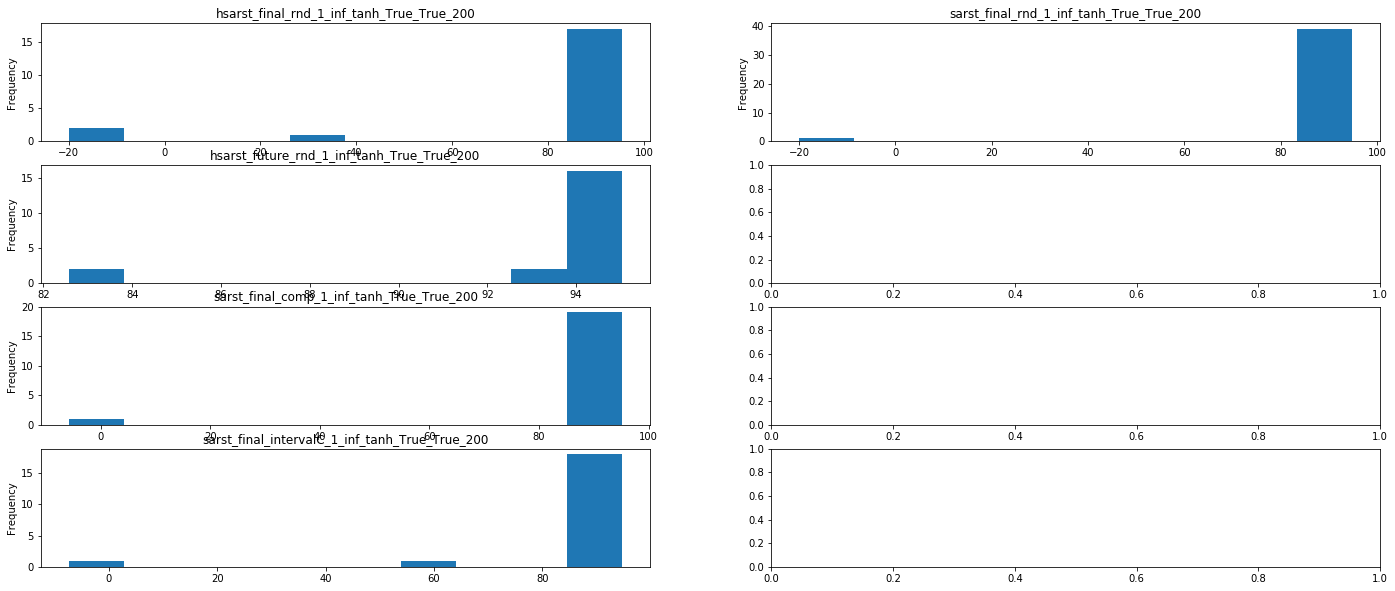

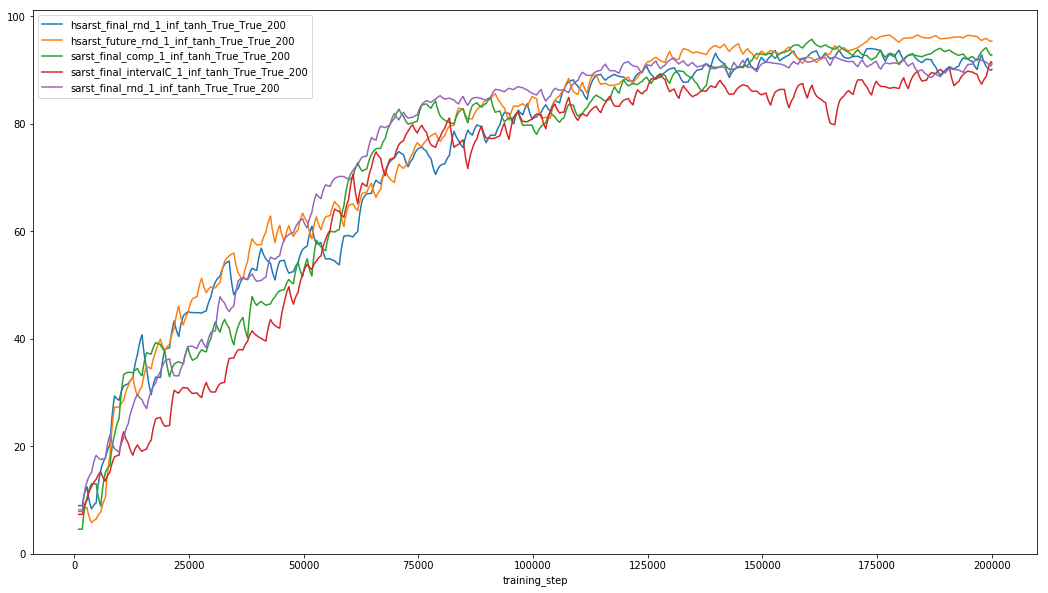

In [19]:
means_steps['Test reward on random goal'] = means_steps.groupby('params')['Test reward on random goal'].apply(lambda x: x.ewm(5).mean())
fig, ax = plt.subplots(figsize=(18,10))
for name, g in means_steps.groupby(['params'])[['training_step','Test reward on random goal']]:
    g.plot(x='training_step',y='Test reward on random goal', label=name, ax=ax)

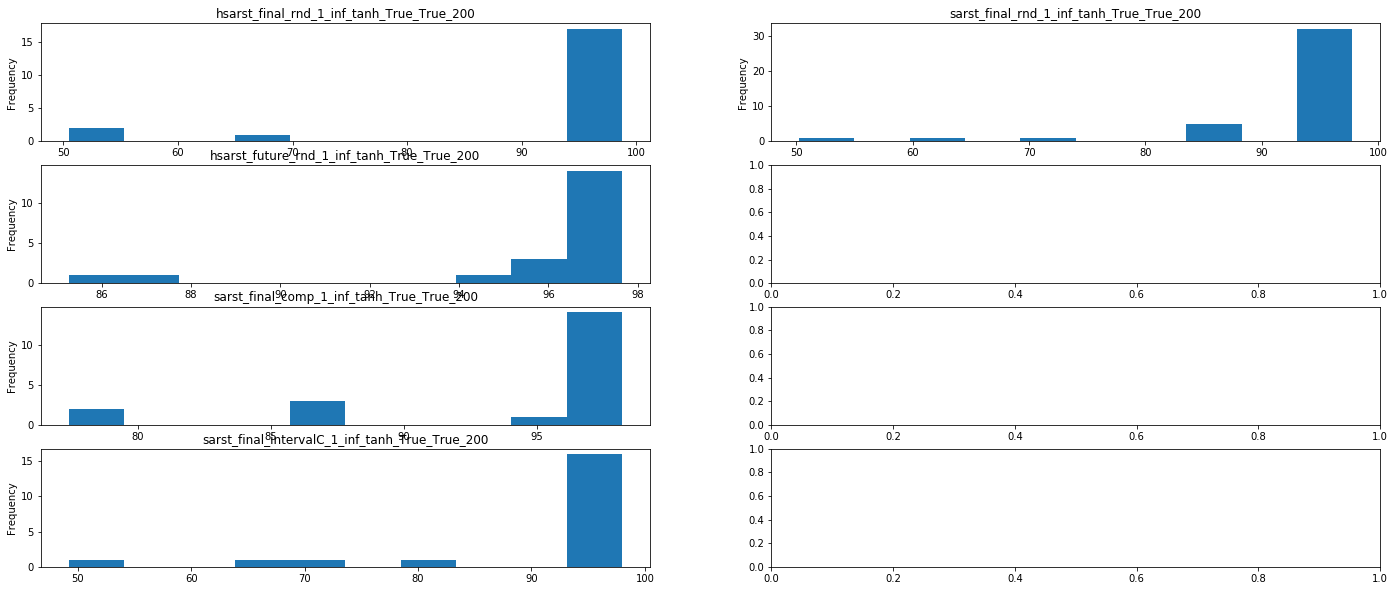

In [20]:
fig, axes = plt.subplots(4,2, figsize=(24,10))
for i,(name, g) in enumerate(res_final.groupby('params')['Test reward on random goal']):
    g.plot(kind='hist', title=name, ax=axes[i%4, i//4])

In [19]:
frames = []
for PARAM in PARAMS:
    param_vals = PARAM.split('_')
    param_names = ['memory', 'strategy', 'sampler', 'alpha', 'delta', 'activation', 'invert_grads', 'target_clip']
    res_episodes = glob.glob(LOGDIR + PARAM + '/*/' + 'log_episodes/progress.json')
    for num_run, run in enumerate(res_episodes):
        try:
            df = pd.read_json(run, lines=True)
        except ValueError:
            print("invalid")
        df['params'] = PARAM
        df['num_run']=num_run
        frames.append(df)
expe_res_episodes = pd.concat(frames, ignore_index=True)
expe_res_episodes

,Duration,Episode,Episode steps,Goal,Goal reached,Start,Train reward,Train step,params,num_run
0,7.894050,1,262,-0.301667,1,-0.546436,99.378046,262,sarst_final_rnd_1_inf_linear_True_False_1000,0
1,102.731069,2,1000,0.200417,1,-0.455342,-69.166653,1262,sarst_final_rnd_1_inf_linear_True_False_1000,0
2,195.081424,3,1000,0.529068,1,-0.417209,-96.111885,2262,sarst_final_rnd_1_inf_linear_True_False_1000,0
3,288.765478,4,1000,0.078793,1,-0.521846,-64.369100,3262,sarst_final_rnd_1_inf_linear_True_False_1000,0
4,382.884678,5,1000,0.346282,1,-0.587518,-45.436014,4262,sarst_final_rnd_1_inf_linear_True_False_1000,0
5,383.813540,6,16,-0.263813,2,-0.424731,98.869743,4278,sarst_final_rnd_1_inf_linear_True_False_1000,0
6,417.070729,7,582,-0.788630,3,-0.470459,63.492290,4860,sarst_final_rnd_1_inf_linear_True_False_1000,0
7,459.153830,8,186,-0.275940,4,-0.578369,98.366745,5046,sarst_final_rnd_1_inf_linear_True_False_1000,0
8,559.911624,9,1000,-0.004656,4,-0.437942,-95.971398,6046,sarst_final_rnd_1_inf_linear_True_False_1000,0
9,657.324387,10,1000,-1.154962,4,-0.528218,-99.954942,7046,sarst_final_rnd_1_inf_linear_True_False_1000,0


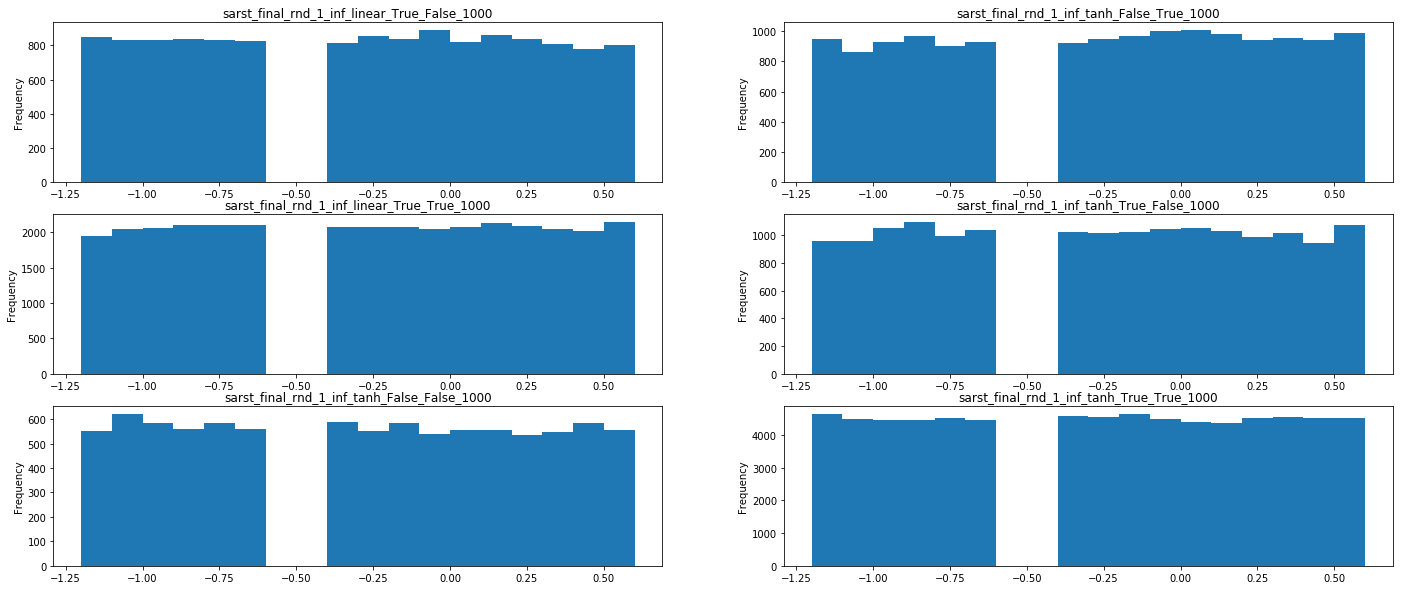

In [22]:
fig, axes = plt.subplots(3,2, figsize=(24,10))
for i,(name, g) in enumerate(expe_res_episodes.groupby('params')['Goal']):
    g.plot(kind='hist', title=name, ax=axes[i%3, i//3], bins=18)